# NLP with Disaster Tweets: Tensorflow LSTM-CNN-Glove

### Abstract

In this notebook, I undertook the preprocessing of the dataset and tailored it for DNN training. Initially, I conducted experiments with LSTM, training the embedding layer within the network. However, this approach resulted in overfitting due to the limited size of the training data. Subsequently, I incorporated a 200-dimensional Twitter version of Stanford's [GloVe](https://nlp.stanford.edu/projects/glove/) embeddings, exploring various architectures and ultimately opting for a straightforward LSTM-CNN hybrid model. To refine the model further, I fine-tuned the hyperparameters of the LSTM-CNN hybrid using Bayesian Optimization with Keras Tuner.

### Importing useful libraries

In [1]:
import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

2023-11-13 17:52:45.670161: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-13 17:52:45.703259: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-13 17:52:45.703280: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-13 17:52:45.703293: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-13 17:52:45.709314: I tensorflow/core/platform/cpu_feature_g

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

2023-11-13 17:52:47.756837: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-13 17:52:47.765815: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-13 17:52:47.766054: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
# for reproducibility
seed0=1337
np.random.seed(seed0) 
tf.keras.utils.set_random_seed(seed0)
tf.config.experimental.enable_op_determinism()

In [5]:
pd.set_option('display.max_colwidth', None)

In [6]:
import string
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/pelin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
from nltk.corpus import stopwords
import re

## Preprocessing

In [8]:
df=pd.read_csv("train.csv")

In [9]:
display(df.shape)
display(df.head(5))

(7613, 5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [10]:
#splitting dataset to train-test segments for training and validation
def parse_data_from_dataframe(df):
    sentences = df['text']
    labels = df['target']
    X_train, X_test, y_train, y_test = train_test_split(sentences,
                                                  labels,
                                                  test_size=0.25,
                                                  random_state=seed0,
                                                       shuffle=True)
    
    return X_train, X_test, y_train, y_test

Source for some of the twitter specific regex: https://www.kaggle.com/code/stoicstatic/twitter-sentiment-analysis-using-word2vec-bilstm 

In [11]:
def remove_stopwords(sentence):
    # Replace all URls with '<url>'
    sentence = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', "<url>", sentence)
    # Adding space on either side of '/' to seperate words (After replacing URLS).
    sentence = re.sub(r'/', ' / ', sentence)
    # Replace @USERNAME to '<user>'.
    sentence = re.sub('@[^\s]+','<user>', sentence)
    # Replace 3 or more consecutive letters by 2 letter.
    sentence = re.sub(r"(.)\1\1+", r"\1\1", sentence)
    
    # Replace all emojis.
    sentence = re.sub(r'<3', '<heart>', sentence)
    sentence = re.sub(r"[8:=;]['`\-]?[)d]+", '<smile>', sentence)
    sentence = re.sub(r"[8:=;]['`\-]?\(+", '<sadface>', sentence)
    sentence = re.sub(r"[8:=;]['`\-]?[\/|l*]", '<neutralface>', sentence)
    sentence = re.sub(r"[8:=;]['`\-]?p+", '<lolface>', sentence)
    

    #removing punctuation
    sentence  = "".join([char for char in sentence if char not in string.punctuation])
    #removing numerics
    sentence = re.sub('[0-9]+', '', sentence)
    
    #stopwords_list = list(set(stopwords.words('english')))
    #sentence=[x for x in sentence if x not in stopwords_list]
    sentence = sentence.lower().split()
    
    return " ".join(sentence)

In [12]:
X_train, X_test, y_train, y_test = parse_data_from_dataframe(df)

In [13]:
#checking samples from the dataset before preprocess
X_train[51:59]

111                                                                                  So i guess no one actually wants any free Aftershock TC.....
1938                              Had to cancel my cats doctor appointment because she decided to go out and play and not come home by curfew ...
3053                                                                 M1.57 [01:11 UTC]?3km NNW of Lake Henshaw California. http://t.co/f9KQksoSw3
7177             70 years ago today the U.S.  dropped a nuclear weapon on Japan. Here are some articles that share my opinion on that decisionÛ_
6040                                        New post from @SeismicSoftware: 3 Major Challenges of Channel Sales Enablement http://t.co/kWMRCEkVTF
3254                                                         @godsfirstson1 and she wrapped his coat around herself. It practically engulfed her.
3558    @FinancialTimes Ethiopian regimes continue receiving foreign aid when famine struck for 2 years eastern Ethiopia  ht

In [14]:
X_train=X_train.apply(remove_stopwords)
X_test=X_test.apply(remove_stopwords)

In [15]:
#checking samples from the dataset after preprocess
X_train[51:59]

111                                                                      so i guess no one actually wants any free aftershock tc
1938                 had to cancel my cats doctor appointment because she decided to go out and play and not come home by curfew
3053                                                                                  m utckm nnw of lake henshaw california url
7177    years ago today the us dropped a nuclear weapon on japan here are some articles that share my opinion on that decisionû
6040                                                         new post from user major challenges of channel sales enablement url
3254                                                    user and she wrapped his coat around herself it practically engulfed her
3558                     user ethiopian regimes continue receiving foreign aid when famine struck for years eastern ethiopia url
44                                                         i wanted to set chicago ablaze with my

In [16]:
print(f"There are {len(X_train)} sentences in the dataset.\n")

max_len_train=X_train.str.split().map(lambda x: len(x)).max()
print("Train set info:")
print(f"First sentence has {len(X_train.head(1).values[0].split())} words (after removing stopwords).\n")
print(f"Max lenght of sentence has {max_len_train} words (after removing stopwords).\n")
print(f"There are {len(y_train)} labels in the dataset.\n")
print(f"The first 5 labels are {y_train.head(5)}\n\n")

max_len_test=X_test.str.split().map(lambda x: len(x)).max()
print("Test set info:")
print(f"There are {len(X_test)} sentences in the dataset.\n")
print(f"First sentence has {len(X_test.head(1).values[0].split())} words (after removing stopwords).\n")
print(f"Max lenght of sentence has {max_len_train} words (after removing stopwords).\n")
print(f"There are {len(y_test)} labels in the dataset.\n")
print(f"The first 5 labels are {y_test.head(5)}\n\n")

There are 5709 sentences in the dataset.

Train set info:
First sentence has 7 words (after removing stopwords).

Max lenght of sentence has 32 words (after removing stopwords).

There are 5709 labels in the dataset.

The first 5 labels are 6303    0
2531    1
5592    0
3599    0
5177    0
Name: target, dtype: int64


Test set info:
There are 1904 sentences in the dataset.

First sentence has 14 words (after removing stopwords).

Max lenght of sentence has 32 words (after removing stopwords).

There are 1904 labels in the dataset.

The first 5 labels are 1948    0
5508    0
5041    0
4147    0
5108    1
Name: target, dtype: int64




In [17]:
max_length = 32
trunc_type='post'
oov_tok = "<OOV>"
padding = 'post'

In [18]:
# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words = len(X_train), oov_token=oov_tok)

In [19]:
# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
vocab_size = len(word_index)

In [20]:
print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 12661 words

<OOV> token included in vocabulary


In [21]:
def seq_pad_and_trunc(sentences, tokenizer, padding, trunc_type, max_length):
    sequences = tokenizer.texts_to_sequences(sentences)
    padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)
    return padded

In [22]:
# Generating and padding the training sequences
padded = seq_pad_and_trunc(X_train, tokenizer, padding, trunc_type, max_length)
# Generating and padding the test sequences
testing_padded = seq_pad_and_trunc(X_test, tokenizer, padding, trunc_type, max_length)

## Training an LSTM Model with Self-Trained Embeddings

In [23]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [24]:
def call():
        es = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', # metrics to monitor
        min_delta=0,#min amoung to count as an improvement
        patience=10, # how many epochs before stop
        verbose=1,
        mode='min', # we need the min loss
        restore_best_weights=True)
            
        rp = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        verbose=1,
        mode='min',
        min_lr=1e-8)
        
        return es,rp
callbacks = call()

In [25]:
# Parameters
embedding_dim = 32
lstm_dim = 32
dense_dim = 64

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim, dropout=0.2)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Setting the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.experimental.Nadam(5e-5),
                   metrics=['accuracy'])

# Printing the model summary
model_lstm.summary()

2023-11-13 17:53:00.385074: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-13 17:53:00.385404: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-13 17:53:00.385583: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 32)            405152    
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 426017 (1.63 MB)
Trainable params: 426017 (1.63 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [26]:
NUM_EPOCHS = 100
BATCH_SIZE = 128

# Training the model
history_lstm = model_lstm.fit(padded, y_train, 
                              batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, 
                              callbacks=[callbacks],
                              validation_data=(testing_padded, y_test))

Epoch 1/100


2023-11-13 17:53:02.814181: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-13 17:53:03.268534: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f20d9a676b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-13 17:53:03.268554: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2023-11-13 17:53:03.275877: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-13 17:53:03.594221: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


45/45 [==============================] - 17s 307ms/step - loss: 0.6928 - accuracy: 0.5166 - val_loss: 0.6916 - val_accuracy: 0.5614 - lr: 5.0000e-05
Epoch 2/100
45/45 [==============================] - 10s 223ms/step - loss: 0.6901 - accuracy: 0.5747 - val_loss: 0.6896 - val_accuracy: 0.5614 - lr: 5.0000e-05
Epoch 3/100
45/45 [==============================] - 7s 149ms/step - loss: 0.6881 - accuracy: 0.5735 - val_loss: 0.6877 - val_accuracy: 0.5614 - lr: 5.0000e-05
Epoch 4/100
45/45 [==============================] - 6s 125ms/step - loss: 0.6858 - accuracy: 0.5733 - val_loss: 0.6858 - val_accuracy: 0.5614 - lr: 5.0000e-05
Epoch 5/100
45/45 [==============================] - 5s 120ms/step - loss: 0.6835 - accuracy: 0.5733 - val_loss: 0.6839 - val_accuracy: 0.5614 - lr: 5.0000e-05
Epoch 6/100
45/45 [==============================] - 7s 148ms/step - loss: 0.6806 - accuracy: 0.5733 - val_loss: 0.6821 - val_accuracy: 0.5614 - lr: 5.0000e-05
Epoch 7/100
45/45 [==============================]

### Assessing Model Performance

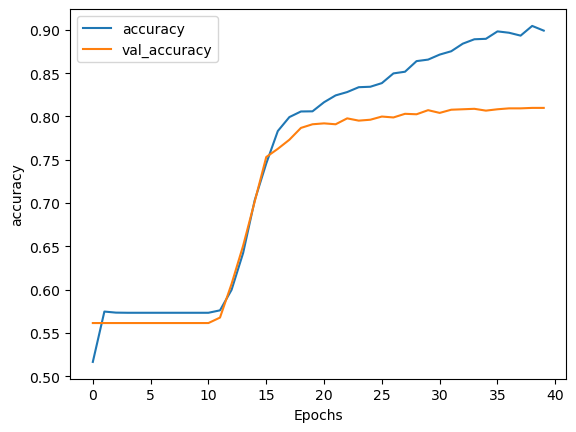

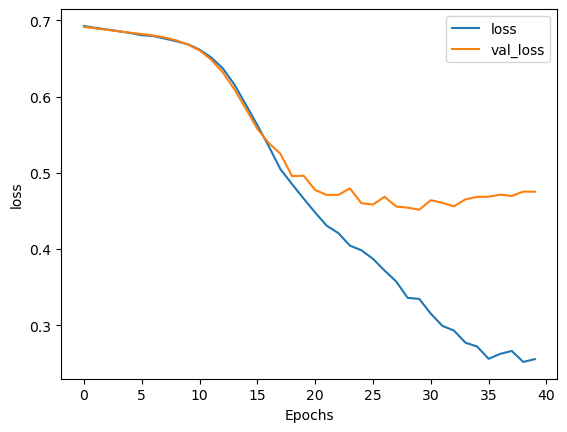

In [27]:
# Plotting the accuracy and loss history
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

60/60 [==============================] - 1s 6ms/step
****** Test Data ********
F1: 0.7596594629993452
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1069
           1       0.84      0.69      0.76       835

    accuracy                           0.81      1904
   macro avg       0.81      0.79      0.80      1904
weighted avg       0.81      0.81      0.80      1904

Confusion Matrix


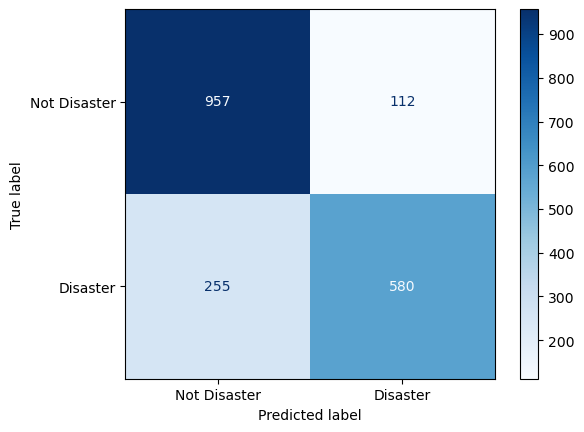

In [28]:
y_pred_valid = tf.math.round(model_lstm.predict(testing_padded)).numpy().astype(int) 
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
print("****** Test Data ********")
print(f"F1: {metrics.f1_score(y_test, y_pred_valid)}")
# Printing performance details
print(metrics.classification_report(y_test, y_pred_valid))

# Printing confusion matrix
print("Confusion Matrix")
ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred_valid,
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

Upon evaluating the model, it becomes evident that there is a pronounced overfitting issue to the training set, particularly in the initial epochs. This can be attributed to the constraint posed by the limited size of the training data. Given the challenges associated with small datasets, a pragmatic strategy is to leverage transfer learning. In my approach, I aim to enhance performance by transferring embeddings generated through training on a larger dataset.

In [29]:
#Resets all state generated by Keras.
tf.keras.backend.clear_session()
del model_lstm
del history_lstm

## Building an LSTM-CNN Model with GloVe Embedding Transfer for Training

Using the 200 dimension Twitter version of [GloVe](https://nlp.stanford.edu/projects/glove/) from Stanford.

In [30]:
#!wget https://nlp.stanford.edu/data/glove.twitter.27B.zip

In [31]:
#!unzip -q glove.twitter.27B.zip

In [32]:
GLOVE_EMBEDDINGS = {}

# Reading the file and filling GLOVE_EMBEDDINGS with its contents
with open("glove.twitter.27B.200d.txt") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs
print("Found %s word vectors." % len(GLOVE_EMBEDDINGS))

Found 1193514 word vectors.


In [33]:
test_word = 'sadface'

test_vector = GLOVE_EMBEDDINGS[test_word]

print(f"Vector representation of word {test_word} looks like this:\n\n{test_vector}")

Vector representation of word sadface looks like this:

[ 0.13942    0.14942   -0.083049  -0.22694   -0.17719    0.068621
  0.32751    0.29046   -0.98112   -0.055128  -0.32885   -0.028781
  0.13015   -0.62901   -0.26694   -0.49831   -0.028981   0.53447
 -0.74758    0.46059    0.20023   -0.52688    0.88961    0.20244
 -0.3154     0.76178   -0.097853   0.051232   0.31198    0.28984
 -0.33384    0.79756    0.020365  -0.48581    0.22673    0.08533
  0.5413     0.032684   0.34624   -0.0050298  0.69359    0.79652
  0.36373   -0.026102  -0.25161    0.94031    0.35078   -0.27898
 -0.016592   0.4419     0.33657    0.22511   -0.14285   -0.12429
  0.32822    0.23203    0.22721    0.40608   -0.088886   0.10732
  0.024414  -0.47135    0.35159   -0.20438   -0.59589   -0.17563
 -0.01621    0.0184    -0.0043566 -0.14127    0.52329   -0.30056
  0.17157   -0.069917   0.21397    0.04184   -0.33831   -0.40201
 -0.098991   0.69844   -0.061859  -0.21282    0.2322     0.077196
 -0.17289   -0.014947   0.09605

In [34]:
EMBEDDING_DIM = 200
# Initializing an empty numpy array with the appropriate size
EMBEDDINGS_MATRIX = np.zeros((vocab_size+1, EMBEDDING_DIM))

# Iterating all of the words in the vocabulary and if the vector representation for 
# the word exists within GloVe's representations, saving it in the EMBEDDINGS_MATRIX array
for word, i in word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector

In [35]:
embedding_layer = tf.keras.layers.Embedding(
    vocab_size+1,
    EMBEDDING_DIM,
    input_length=max_length, 
    weights=[EMBEDDINGS_MATRIX], 
    trainable=False
)

In [36]:
#Resets all state generated by Keras.
#tf.keras.backend.clear_session()
#del model_lstm
#del history_lstm

In [37]:
# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200,dropout=0.50,return_sequences=True)),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, dropout=0.50,return_sequences=True)),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Conv1D(200, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


# Setting the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.experimental.Nadam(5e-5),
                   metrics=['accuracy'])

# Printing the model summary
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 200)           2532400   
                                                                 
 spatial_dropout1d (Spatial  (None, 32, 200)           0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 32, 400)           641600    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 400)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 32, 200)           400800    
 onal)                                                           
                                                        

In [38]:
NUM_EPOCHS = 100
BATCH_SIZE = 64

# Training the model
history_lstm = model_lstm.fit(padded, y_train, 
                              batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, 
                              callbacks=[callbacks],
                              validation_data=(testing_padded, y_test))

Epoch 1/100
90/90 [==============================] - 8s 40ms/step - loss: 0.6669 - accuracy: 0.6036 - val_loss: 0.6067 - val_accuracy: 0.7616 - lr: 5.0000e-05
Epoch 2/100
90/90 [==============================] - 3s 29ms/step - loss: 0.5711 - accuracy: 0.7387 - val_loss: 0.4999 - val_accuracy: 0.7757 - lr: 5.0000e-05
Epoch 3/100
90/90 [==============================] - 3s 29ms/step - loss: 0.5193 - accuracy: 0.7642 - val_loss: 0.4758 - val_accuracy: 0.7904 - lr: 5.0000e-05
Epoch 4/100
90/90 [==============================] - 3s 30ms/step - loss: 0.5003 - accuracy: 0.7768 - val_loss: 0.4562 - val_accuracy: 0.8067 - lr: 5.0000e-05
Epoch 5/100
90/90 [==============================] - 3s 30ms/step - loss: 0.4870 - accuracy: 0.7765 - val_loss: 0.4539 - val_accuracy: 0.8036 - lr: 5.0000e-05
Epoch 6/100
90/90 [==============================] - 3s 30ms/step - loss: 0.4766 - accuracy: 0.7875 - val_loss: 0.4424 - val_accuracy: 0.8078 - lr: 5.0000e-05
Epoch 7/100
90/90 [===========================

### Assessing Model Performance

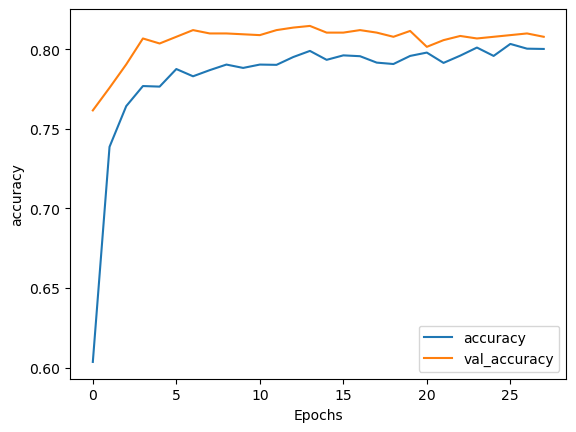

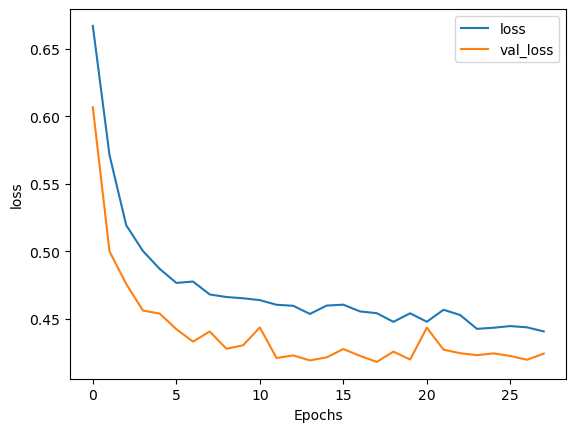

In [39]:
# Plotting the accuracy and loss history
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

60/60 [==============================] - 2s 11ms/step
****** Test Data ********
F1: 0.7687379884689302
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1069
           1       0.83      0.72      0.77       835

    accuracy                           0.81      1904
   macro avg       0.81      0.80      0.80      1904
weighted avg       0.81      0.81      0.81      1904

Confusion Matrix


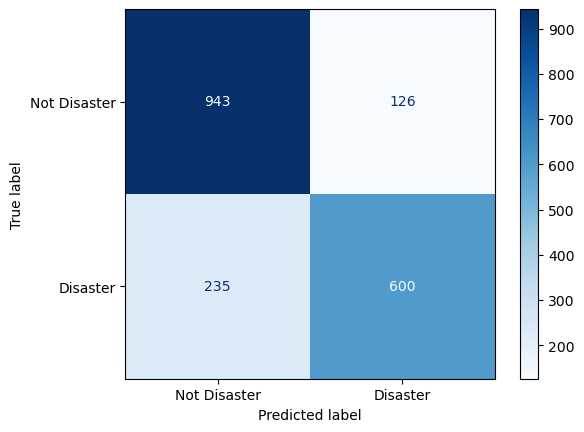

In [40]:
y_pred_valid = tf.math.round(model_lstm.predict(testing_padded)).numpy().astype(int) 
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
print("****** Test Data ********")
print(f"F1: {metrics.f1_score(y_test, y_pred_valid)}")
# Printing performance details
print(metrics.classification_report(y_test, y_pred_valid))

# Printing confusion matrix
print("Confusion Matrix")
ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred_valid,
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

In [41]:
tf.keras.backend.clear_session()
del model_lstm
del history_lstm

## Optimizing Hyperparameters for LSTM-CNN-GloVe Embeddings Model through Bayesian Tuning

In [42]:
import keras_tuner as kt

In [43]:
def call():
        es = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', # metrics to monitor
        min_delta=0,#min amoung to count as an improvement
        patience=10, # how many epochs before stop
        verbose=0,
        mode='min', # we need the min loss
        restore_best_weights=True)
            
        rp = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        verbose=0,
        mode='min',
        min_lr=1e-8)
        
        return es,rp
callbacks = call()

In [44]:
#tf.keras.backend.clear_session()
#del tuner_lr_do
#del final_model

In [45]:
def model_builder(hp):
    model = tf.keras.Sequential()
    model.add(embedding_layer)
    
    hp_dropout1=hp.Float('drop_out1', min_value=0.0, max_value=0.5, step=0.1)
    model.add(tf.keras.layers.SpatialDropout1D(hp_dropout1))
    
    hp_dropout2=hp.Float('drop_out2', min_value=0.0, max_value=0.5, step=0.1)
    hp_units1 = hp.Int('units1', min_value=32, max_value=256, step=32)
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hp_units1,dropout=hp_dropout2,return_sequences=True)))
    
    hp_dropout3=hp.Float('drop_out3', min_value=0.0, max_value=0.5, step=0.1)
    model.add(tf.keras.layers.Dropout(hp_dropout3))
    
    hp_dropout4=hp.Float('drop_out4', min_value=0.0, max_value=0.5, step=0.1)
    hp_units2 = hp.Int('units2', min_value=32, max_value=256, step=32)
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hp_units2, dropout=hp_dropout4,return_sequences=True)))
    
    hp_dropout5=hp.Float('drop_out5', min_value=0.0, max_value=0.5, step=0.1)
    model.add(tf.keras.layers.Dropout(hp_dropout5))
    
    hp_dropout6=hp.Float('drop_out6', min_value=0.0, max_value=0.5, step=0.1)
    hp_units3 = hp.Int('units3', min_value=32, max_value=256, step=32)
    model.add(tf.keras.layers.Conv1D(hp_units3, 5, activation='relu'))
    model.add(tf.keras.layers.GlobalMaxPool1D())
    model.add(tf.keras.layers.Dropout(hp_dropout6))
    
    hp_dropout7=hp.Float('drop_out7', min_value=0.0, max_value=0.5, step=0.1)
    hp_units4 = hp.Int('units4', min_value=32, max_value=256, step=32)
    model.add(tf.keras.layers.Dense(hp_units4, activation='relu'))
    model.add(tf.keras.layers.Dropout(hp_dropout7))
    
    hp_dropout8=hp.Float('drop_out8', min_value=0.0, max_value=0.5, step=0.1)
    hp_units5 = hp.Int('units5', min_value=32, max_value=256, step=32)
    model.add(tf.keras.layers.Dense(hp_units5, activation='relu'))
    model.add(tf.keras.layers.Dropout(hp_dropout8))
    
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[5e-5, 3e-5])
    model.compile(loss='binary_crossentropy', 
                       optimizer=tf.keras.optimizers.experimental.Nadam(learning_rate=hp_learning_rate),
                   metrics=['accuracy'])
    return model

In [46]:
tuner_lr_do = kt.BayesianOptimization(model_builder,
                     objective='val_accuracy',
                     max_trials=60,
                     seed=seed0,      
                     overwrite=True,
                     directory='my_dir',
                     project_name='lr_do_to_kt')

In [47]:
NUM_EPOCHS = 100
BATCH_SIZE = 64
tuner_lr_do.search(padded, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, 
                              callbacks=[callbacks],verbose=0,
                              validation_data=(testing_padded, y_test))

In [48]:
best_hps=tuner_lr_do.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.\n The optimal drop-out1 is {best_hps.get('drop_out1')}
\n The optimal units1 is {best_hps.get('units1')} 
\n The optimal drop-out2 is {best_hps.get('drop_out2')} 
\n The optimal drop-out3 is {best_hps.get('drop_out3')} 
\n The optimal units2 is {best_hps.get('units2')} 
\n The optimal drop-out4 is {best_hps.get('drop_out4')} 
\n The optimal drop-out5 is {best_hps.get('drop_out5')} 
\n The optimal units3 is {best_hps.get('units3')} 
\n The optimal drop-out6 is {best_hps.get('drop_out6')} 
\n The optimal units4 is {best_hps.get('units4')} 
\n The optimal drop-out7 is {best_hps.get('drop_out7')} 
\n The optimal units5 is {best_hps.get('units5')} 
\n The optimal drop-out8 is {best_hps.get('drop_out8')} 
\n and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete.
 The optimal drop-out1 is 0.0

 The optimal units1 is 32 

 The optimal drop-out2 is 0.1 

 The optimal drop-out3 is 0.1 

 The optimal units2 is 224 

 The optimal drop-out4 is 0.2 

 The optimal drop-out5 is 0.2 

 The optimal units3 is 224 

 The optimal drop-out6 is 0.4 

 The optimal units4 is 128 

 The optimal drop-out7 is 0.0 

 The optimal units5 is 128 

 The optimal drop-out8 is 0.30000000000000004 

 and the optimal learning rate for the optimizer is 3e-05.



In [49]:
tunned_model_lstm=tuner_lr_do.hypermodel.build(best_hps)
tunned_model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 200)           2532400   
                                                                 
 spatial_dropout1d_1 (Spati  (None, 32, 200)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_2 (Bidirecti  (None, 32, 64)            59648     
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 32, 64)            0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 32, 448)           517888    
 onal)                                                           
                                                      

In [50]:
final_model=tunned_model_lstm.fit(padded, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, 
                              callbacks=[callbacks],
                              validation_data=(testing_padded, y_test))

Epoch 1/100
90/90 [==============================] - 10s 42ms/step - loss: 0.6806 - accuracy: 0.5654 - val_loss: 0.6646 - val_accuracy: 0.5935 - lr: 3.0000e-05
Epoch 2/100
90/90 [==============================] - 3s 28ms/step - loss: 0.6294 - accuracy: 0.6921 - val_loss: 0.5667 - val_accuracy: 0.7553 - lr: 3.0000e-05
Epoch 3/100
90/90 [==============================] - 3s 29ms/step - loss: 0.5383 - accuracy: 0.7528 - val_loss: 0.4944 - val_accuracy: 0.7752 - lr: 3.0000e-05
Epoch 4/100
90/90 [==============================] - 2s 27ms/step - loss: 0.5053 - accuracy: 0.7709 - val_loss: 0.4803 - val_accuracy: 0.7831 - lr: 3.0000e-05
Epoch 5/100
90/90 [==============================] - 3s 28ms/step - loss: 0.4901 - accuracy: 0.7767 - val_loss: 0.4673 - val_accuracy: 0.7925 - lr: 3.0000e-05
Epoch 6/100
90/90 [==============================] - 2s 26ms/step - loss: 0.4815 - accuracy: 0.7839 - val_loss: 0.4615 - val_accuracy: 0.7967 - lr: 3.0000e-05
Epoch 7/100
90/90 [==========================

90/90 [==============================] - 3s 30ms/step - loss: 0.3992 - accuracy: 0.8255 - val_loss: 0.4128 - val_accuracy: 0.8120 - lr: 1.2000e-06
Epoch 53/100
90/90 [==============================] - 3s 29ms/step - loss: 0.4001 - accuracy: 0.8241 - val_loss: 0.4129 - val_accuracy: 0.8141 - lr: 1.2000e-06
Epoch 54/100
90/90 [==============================] - 2s 25ms/step - loss: 0.3963 - accuracy: 0.8233 - val_loss: 0.4129 - val_accuracy: 0.8141 - lr: 1.2000e-06
Epoch 55/100
90/90 [==============================] - 2s 27ms/step - loss: 0.3977 - accuracy: 0.8255 - val_loss: 0.4128 - val_accuracy: 0.8141 - lr: 1.2000e-06


### Assessing Model Performance

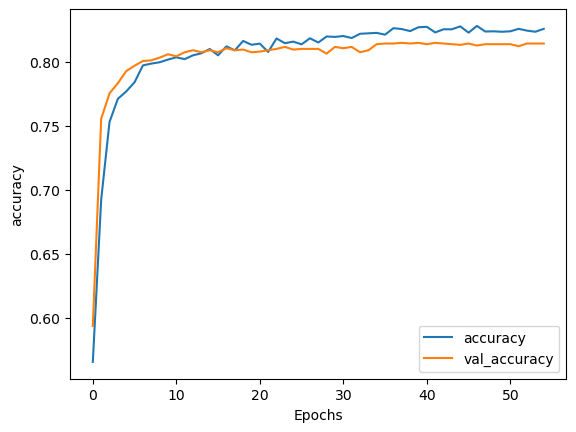

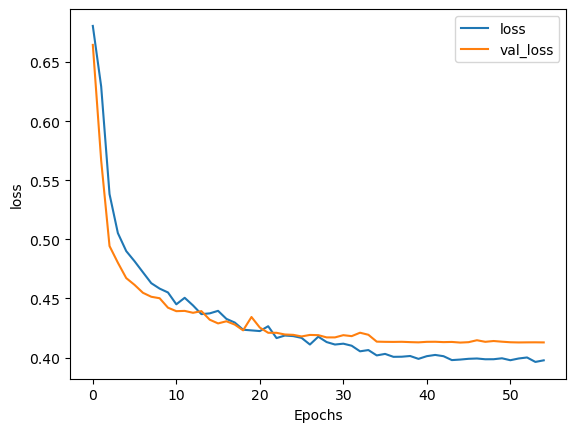

In [51]:
# Plotting the accuracy and loss history
plot_graphs(final_model, 'accuracy')
plot_graphs(final_model, 'loss')

60/60 [==============================] - 1s 10ms/step
****** Test Data ********
F1: 0.7667103538663173
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1069
           1       0.85      0.70      0.77       835

    accuracy                           0.81      1904
   macro avg       0.82      0.80      0.81      1904
weighted avg       0.82      0.81      0.81      1904

Confusion Matrix


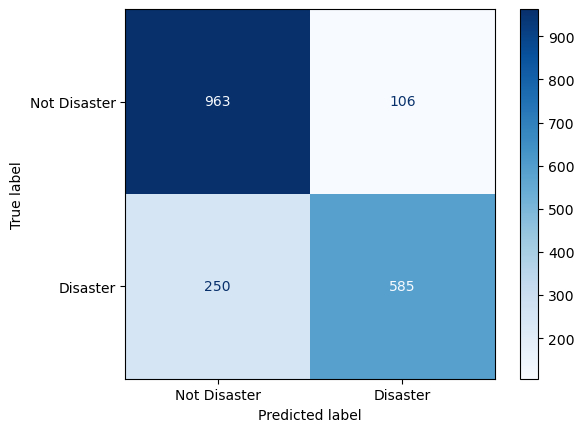

In [52]:
y_pred_valid = tf.math.round(tunned_model_lstm.predict(testing_padded)).numpy().astype(int) 
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
print("****** Test Data ********")
print(f"F1: {metrics.f1_score(y_test, y_pred_valid)}")
# Printing performance details
print(metrics.classification_report(y_test, y_pred_valid))

# Printing confusion matrix
print("Confusion Matrix")
ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred_valid,
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

### Exploring Misclassifications: A Glimpse into Incorrect Classifications

In [53]:
#checking misclasifications
maxtoshow=10
flattened_preds=y_pred_valid.flatten()
np_y_test=y_test.to_numpy()
np_X_test=X_test.to_numpy()
errors = flattened_preds != np_y_test
counter=0
for i in range(X_test.shape[0]):
    if counter>=maxtoshow:
        break   
    if errors[i]:
        print("*"*66)
        print(f"predicted: {flattened_preds[i]} , actual: {np_y_test[i]}")
        print(np_X_test[i])
        counter+=1

******************************************************************
predicted: 0 , actual: 1
photo blue by user source url url
******************************************************************
predicted: 0 , actual: 1
user smile well i think that sounds like a fine plan where little derailment is possible so i applaud you smile
******************************************************************
predicted: 0 , actual: 1
he came to a land which was engulfed in tribal war and turned it into a land of peace ie madinah prophetmuhammad islam
******************************************************************
predicted: 1 , actual: 0
coastal german shepherd rescue oc shared a link ecstatic rescued racco url animalrescue
******************************************************************
predicted: 1 , actual: 0
nikoniko breaking news unconfirmed i just heard a loud bang nearby in what appears to be a blast of wind from my neighbours ass
***********************************************************

## Predicting Test Set Outcomes

In [54]:
df_test=pd.read_csv("test.csv")
sentences_test = df_test['text']

In [55]:
sentences_test=sentences_test.apply(remove_stopwords)
df_test_padded = seq_pad_and_trunc(sentences_test, tokenizer, padding, trunc_type, max_length)

In [56]:
final_out=pd.DataFrame(columns=['id', 'target'])

In [57]:
final_out['id']=df_test['id']
final_out['target'] = tf.math.round(tunned_model_lstm.predict(df_test_padded)).numpy().astype(int) 

102/102 [==============================] - 1s 11ms/step


In [58]:
final_out.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
